# Find the most relevant jobs to my profile

## Retrieve Data
- find all jobs related to three keywords “data scientist”, “data analyst” and “data python” on jobs.ch.
- Download all necessary information (including job text).

## Analyze Data
Using the information obtained perform a descriptive analysis on this data including questions:


- How many jobs are shared between these categories?
- Are there some companies doing more hires than average? 
- How many jobs are there in different Kantons?
- Is “machine learning” keyword most often in data scientist jobs or data analyst?
- What is the distribution of most common keywords between and across categories (Bonus)?

## Retrieve Data

### import libs

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

### Generate list of links to all open positions for all keywords

In [11]:
# build web page names:
rootstr = 'https://www.jobs.ch/en/vacancies/?page='
rootstr_2 = 'https://www.jobs.ch'
linksatr = '&term='
keyword_list = ['Data%20Scientist','Data%20Analyst','Data%20Python']

     
link_list = []
query_type = []
#t = time.time

for x in tqdm(range(0,len(keyword_list))):
    
    # build first page
    init_page = rootstr + '1' + linksatr + keyword_list[x]
    
    # find last page
    response = requests.get(init_page, timeout=100)

    obj = BeautifulSoup(response.content, "html.parser")
    obj_1 = obj.find('body').find('div',{'id':'react-root'}).find('div',{'class':'view-container'})
    obj_2 = obj_1.find('div',{'class':'content-wrap'}).find('div',{'class':'content content--vacancy-search'})
    last_page = obj_2.find('div',{'class':'box shadow-2'}).find('div',{'class':'paginator'}).find('li',{'class':'page hidden-xs last'}).find('a').get_text()

    # generate links to all pages
    
    for y in range(1,int(last_page)+1):
        curr_link = '%s%d%s%s' % (rootstr,y,linksatr,keyword_list[x])
               
        # use every page link to get links to all open positions 
        curr_response = requests.get(curr_link, timeout=100)
        curr_obj = BeautifulSoup(curr_response.content, "html.parser")
        curr_obj_1 = curr_obj.find('body').find('div',{'id':'react-root'}).find('div',{'class':'view-container'})
        curr_obj_2 = curr_obj_1.find('div',{'class':'content-wrap'}).find('div',{'class':'content content--vacancy-search'})
        list_of_jobs = curr_obj_2.find('div',{'class':'organic'}).findAll('div',{'class':'serp-item-job-info'})

        for z in range(0, len(list_of_jobs)):
            curr_joblink = list_of_jobs[z].find('a').get('href')
            curr_full_link = rootstr_2+curr_joblink
            link_list.append(curr_full_link)
            query_type.append(keyword_list[x])

#after_t = time.time() - t

link_list[1:5]


['https://www.jobs.ch/en/vacancies/detail/8959887/?position=1-3&source=vacancy_search',
 'https://www.jobs.ch/en/vacancies/detail/8840492/?position=1-4&source=vacancy_search',
 'https://www.jobs.ch/en/vacancies/detail/8925613/?position=1-5&source=vacancy_search',
 'https://www.jobs.ch/en/vacancies/detail/8882804/?position=1-6&source=vacancy_search']

In [12]:
# reformat query type:   
query_type = [x.replace('%20', ' ') for x in query_type] 
query_type[1:5]

['Data Scientist', 'Data Scientist', 'Data Scientist', 'Data Scientist']

### Generate data frame that contains data from open positions

In [23]:
# initiate data frame
Jobs_DataFrame = pd.DataFrame(columns = ['Query','Job title','Location','Company name','Content'] )

for x in tqdm(range(0, len(link_list))):
    
    curr_query_type = query_type[x]

    response2 = requests.get(link_list[x], timeout=100)

    job_obj = BeautifulSoup(response2.content, "html.parser")

    try:
        job_title = job_obj.find('h1', {'class': 'e-heading vacancy-ad-title h-base x--vacancy-title'}).get_text()
    except:
        job_title = np.nan
    try:
        job_content = job_obj.find('div', {'class': 'container vacancy-detail-content'}).get_text()
    except:
        job_content = np.nan
    try:
        job_location = job_obj.find('span', {'class': 'svg-icon icon icon-location'}).next_sibling
    except:
        job_location = np.nan
    try:
        company = job_obj.find('div', {'class' : 'vacancy-ad-company x--vacancy-ad-company'}).find('span').get_text()
    except:
        company = np.nan

    Jobs_DataFrame = Jobs_DataFrame.append({
        'Query':curr_query_type,
        'Job title':job_title,
        'Location':job_location,
        'Company name': company, 
        'Content':job_content}, ignore_index=True)
    

In [25]:
Jobs_DataFrame.head(5)

,Query,Job title,Location,Company name,Content
0,Data Scientist,Product Data Analyst (m/f/d) 100%,Basel,IPS AG,"Established in 1985, IPS offers competent a..."
1,Data Scientist,Data Scientist / Data Analyst / Project Manage...,Zürich,Stamford Consultants AG,...Data Scientist / Data Analyst / Project Man...
2,Data Scientist,"Data Scientist Leistungen (80-100%) in Bern, W...",Bern,KPT Krankenkasse,"Data Scientist Leistungen (80-100%) in Bern, W..."
3,Data Scientist,"Data Scientist Consultant, 100%",Zürich,Credit Suisse AG,"Data Scientist Consultant, 100%Data Scientist ..."
4,Data Scientist,Data & Reporting Developer,Bern,Admeira AG,Data & Reporting DeveloperAdmeira zählt zu den...


### save data

In [26]:
Jobs_DataFrame.to_csv('Jobs_DataFrame.csv', encoding='utf-8', index=False)

### Retrieve the according Kanton for all locations

In [27]:
# clean location names, and translate to German

# use wiki to convert
# wiki_link = 'https://de.wikipedia.org/wiki/'

unique_cities = set(Jobs_DataFrame['Location'])

unique_cities

{'1001 Lausanne',
 '1204 Genève',
 "1344 L'Abbaye",
 '2002 Neuchâtel',
 '3010 Bern',
 '8091 Zürich',
 '9492 Eschen',
 'Aarau',
 'Adliswil, Horgen, Switzerland',
 'Adliswil, ZH',
 'Allschwil',
 'Alpnach / Zürich',
 'Altendorf',
 'Any City',
 'Baar',
 'Bad Zurzach',
 'Baden',
 'Baden / Aargau / Switzerland',
 'Baden, Aargau',
 'Baden-Daettwil',
 'Baden-Dättwil, Aargau',
 'Basel',
 'Basel Hauptsitz/Siège',
 'Basel Headquarter',
 'Basel, Canton of Basel-City',
 'Basel, Switzerland',
 'Basel-Stadt',
 'Bern',
 'Bern Wylerpark',
 'Bern oder Zürich',
 'Bern or Zurich',
 'Bern und Zürich',
 'Bern+Zofingen',
 'Bern, Switzerland',
 'Bern-Liebefeld',
 'Berne',
 'Bettlach, Switzerland',
 'Biel',
 'Biel, Bern',
 'Bogis-Bossey',
 'Bonaduz',
 'Bonaduz GR',
 'Boudry',
 'Bubendorf',
 'Buchs',
 'Buchs ZH (ab 4. Quartal 2019 Cham ZG)',
 'Buchs ZH Cham ZG',
 'CH, ZH, Zurich',
 'CH-Zurich',
 'CHE - Pfäffikon',
 'Canton of Zug',
 'Cheseaux-Lausanne',
 'Chiasso',
 'Chicago',
 'Chêne-Bourg',
 'Corgémont',
 'Co

## Analyze Data

### How many jobs are shared between these categories?

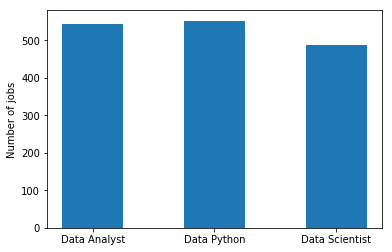

In [29]:
# Jobs_DataFrame = pd.read_csv('Jobs_DataFrame.csv', index_col=0, parse_dates=True)

job_numbers = Jobs_DataFrame.groupby('Query').count().reset_index()

plt.bar(job_numbers['Query'],job_numbers['Content'],width=0.5)
plt.ylabel('Number of jobs')
None

In [31]:
Jobs_DataFrame_unique = Jobs_DataFrame
Jobs_DataFrame_unique = Jobs_DataFrame_unique.drop_duplicates(['Job title','Location','Company name'])
number_shared = len(Jobs_DataFrame) - len(Jobs_DataFrame_unique)
perc_shared = number_shared*100/len(Jobs_DataFrame)

print('%d jobs (%d percent) are shared between the 3 categories.'% (number_shared,perc_shared))

454 jobs (28 percent) are shared between the 3 categories.


### Are there some companies doing more hires than average?

In [35]:
jobs_per_company = Jobs_DataFrame_unique.groupby('Company name').count()
jobs_per_company = jobs_per_company.rename(columns = {'Query':'Number of jobs'})
jobs_per_company = jobs_per_company.sort_values('Number of jobs',ascending=False)

print(jobs_per_company['Number of jobs'][0:3])

Company name
F. Hoffmann-La Roche AG    85
Credit Suisse AG           29
Swisscom (Schweiz) AG      22
Name: Number of jobs, dtype: int64


In [36]:
mean_jobs = jobs_per_company['Number of jobs'].mean()
highest_hiring = jobs_per_company[jobs_per_company['Number of jobs'] > mean_jobs]
highest_hiring = highest_hiring.sort_values('Number of jobs', ascending=False).reset_index()

print('%d out of %d companies have more than the average %.1f positions open' % (len(highest_hiring),len(jobs_per_company),mean_jobs))

60 out of 278 companies have more than the average 2.7 positions open


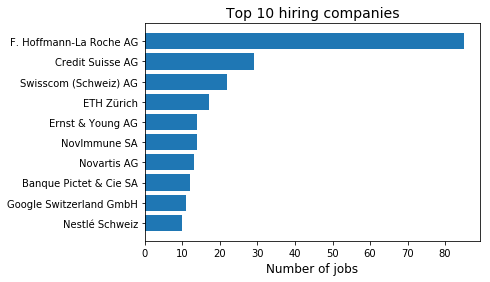

In [121]:
highest_hiring_top = highest_hiring[0:10].sort_values('Number of jobs', ascending=True).reset_index()
plt.barh(highest_hiring_top['Company name'],highest_hiring_top['Number of jobs'])
plt.xlabel('Number of jobs', fontsize=12)
plt.title('Top 10 hiring companies', fontsize=14)
None

### How many jobs are there in different Kantons?

#### oh boy....

### Is “machine learning” keyword most often in data scientist jobs or data analyst?

In [38]:
# find keyword in job description and add result to df
Jobs_DataFrame_keyw = Jobs_DataFrame
keyword = 'machine learning'
list_matches = []

for x in range(0,len(Jobs_DataFrame_keyw)):
    curr_result = Jobs_DataFrame_keyw['Content'][x].lower().find(keyword)
    
    if curr_result >= 0:
        list_matches.append(1)
    elif curr_result < 0:
        list_matches.append(0)
    
Jobs_DataFrame_keyw['machine learning'] = list_matches
Jobs_DataFrame_keyw.head(3)

,Query,Job title,Location,Company name,Content,machine learning
0,Data Scientist,Product Data Analyst (m/f/d) 100%,Basel,IPS AG,"Established in 1985, IPS offers competent a...",0
1,Data Scientist,Data Scientist / Data Analyst / Project Manage...,Zürich,Stamford Consultants AG,...Data Scientist / Data Analyst / Project Man...,0
2,Data Scientist,"Data Scientist Leistungen (80-100%) in Bern, W...",Bern,KPT Krankenkasse,"Data Scientist Leistungen (80-100%) in Bern, W...",0


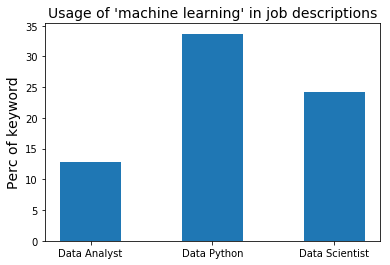

In [122]:
# plot frequency of keyword usage
keyword_use = Jobs_DataFrame_keyw.groupby('Query').sum().reset_index()

perc_match_list = []
for y in range(0,len(keyword_use)):
    perc_match_list.append((keyword_use['machine learning'][y]*100)/job_numbers['Location'][y])
    
keyword_use['percentage of jobs with match'] = perc_match_list

plt.bar(keyword_use['Query'],keyword_use['percentage of jobs with match'],width=0.5)
plt.ylabel('Perc of keyword', fontsize=14)
plt.title('Usage of \'machine learning\' in job descriptions', fontsize=14)
None

### What is the distribution of most common keywords between and across categories (Bonus)?

In [40]:
# find keywords in job description and add result to NEW df

keyword_list = ['deep learning','python','communication','scraping','presentation','research']
keyword_df = pd.DataFrame(columns = keyword_list)

for k in range(0,len(keyword_list)):
    
    curr_keyword = keyword_list[k]
    result_list = [] # delete list every round!
    
    for x in range(0,len(Jobs_DataFrame_keyw)):
        curr_result = Jobs_DataFrame_keyw['Content'][x].lower().find(curr_keyword)
        if curr_result >= 0:
            result_list.append(1)
        elif curr_result < 0:
            result_list.append(0)

    keyword_df[curr_keyword] = result_list
    
keyword_df.head(3)

,deep learning,python,communication,scraping,presentation,research
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,0


In [50]:
# merge df
Jobs_DataFrame_keywords = pd.concat([Jobs_DataFrame_keyw,keyword_df], axis=1, ignore_index=False)
#Jobs_DataFrame_keywords.head(5)

In [66]:
# plot frequency of keyword usage
keyword_use = Jobs_DataFrame_keywords.groupby('Query').sum().reset_index()

keyword_use = pd.concat([keyword_use,job_numbers['Content']], axis=1, ignore_index=False)
keyword_use = keyword_use.rename(columns = {'Content':'Total jobs'})

keyword_use

,Query,machine learning,deep learning,python,communication,scraping,presentation,research,Total jobs
0,Data Analyst,70,15,118,259,2,83,129,544
1,Data Python,186,48,548,217,3,44,188,552
2,Data Scientist,118,27,158,231,0,76,269,488


In [78]:
df_frequency = pd.DataFrame(columns = keyword_use.columns )
df_frequency['Query'] = keyword_use['Query']

df_frequency['machine learning'] = keyword_use['machine learning'] / keyword_use['Total jobs'] 
df_frequency['deep learning'] = keyword_use['deep learning'] / keyword_use['Total jobs'] 
df_frequency['python'] = keyword_use['python'] / keyword_use['Total jobs'] 
df_frequency['communication'] = keyword_use['communication'] / keyword_use['Total jobs'] 
df_frequency['scraping'] = keyword_use['scraping'] / keyword_use['Total jobs'] 
df_frequency['presentation'] = keyword_use['presentation'] / keyword_use['Total jobs'] 
df_frequency['research'] = keyword_use['research'] / keyword_use['Total jobs'] 

del df_frequency['Total jobs']
df_frequency

,Query,machine learning,deep learning,python,communication,scraping,presentation,research
0,Data Analyst,0.128676,0.027574,0.216912,0.476103,0.003676,0.152574,0.237132
1,Data Python,0.336957,0.086957,0.992754,0.393116,0.005435,0.079710,0.340580
2,Data Scientist,0.241803,0.055328,0.323770,0.473361,0.000000,0.155738,0.551230


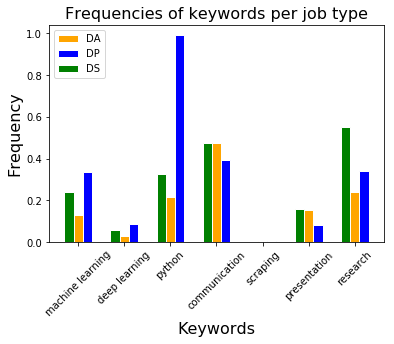

In [116]:
# Grouped bar plot 
pos = np.arange(7)
bar_width = 0.2
DA_freq = df_frequency.iloc[0].tolist()
DP_freq = df_frequency.iloc[1].tolist()
DS_freq = df_frequency.iloc[2].tolist()
 
plt.bar(pos, DA_freq[1:], bar_width, color='orange', edgecolor='white')
plt.bar(pos+bar_width, DP_freq[1:], bar_width, color='blue', edgecolor='white')
plt.bar(pos-bar_width, DS_freq[1:], bar_width, color='green', edgecolor='white')


plt.xticks(pos, df_frequency.columns[1:],rotation=45)
plt.xlabel('Keywords', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Frequencies of keywords per job type',fontsize=16)
plt.legend(['DA','DP','DS'],loc=2)

None